### Importação das bibliotecas 

In [706]:
import pandas as pd
import numpy as np
from unidecode import unidecode
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Leitura do arquivo e conversão para o formato parquet


In [707]:
# Leitura do arvuivo em CSV
emissao_co2 = pd.read_csv("Emissão_CO2_por_países.csv")

# Escrita em Parquet com compressão Snappy (mais comum). Para arquivos pequenos e execução local, é uma alternativa boa.
# Para ambientes distribuidos e arquivos grandes, é mais adequado a utilização do PySpark
emissao_co2.to_parquet("emissao_co2.parquet", engine="pyarrow", compression="snappy")

In [708]:
# Leitura do arquivo em parquet
emissao_co2 = pd.read_parquet("emissao_co2.parquet")

In [709]:
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
0,Afghanistan,Asia,01-01-2011,8930.0,0.31
1,Afghanistan,Asia,01-01-2012,8080.0,0.27
2,None,Asia,01-01-2010,7110.0,0.25
3,None,Asia,01-01-2019,6080.0,0.16
4,None,Asia,01-01-2018,6070.0,0.17


In [710]:
emissao_co2.tail()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
5672,Zimbabwe,None,01-01-2004,9770.0,0.80
5673,Zimbabwe,None,01-01-2007,9760.0,0.78
5674,Zimbabwe,None,01-01-2010,9600.0,0.75
5675,Zimbabwe,None,01-01-2009,7750.0,0.61
5676,Zimbabwe,None,01-01-2008,NaN,0.61


In [711]:
# Obtendo informações gerais sobre a base de dados
emissao_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 5599 non-null   object 
 1   Region                  5653 non-null   object 
 2   Date                    5677 non-null   object 
 3   Kilotons of Co2         5560 non-null   float64
 4   Metric Tons Per Capita  5677 non-null   float64
dtypes: float64(2), object(3)
memory usage: 221.9+ KB


In [712]:
# Verificando valores faltantes
emissao_co2.isnull().sum()

Country                    78
Region                     24
Date                        0
Kilotons of Co2           117
Metric Tons Per Capita      0
dtype: int64

In [713]:
# A base de dados conta com um total de 191 países, sendo que existem occorências vazias
len(set(emissao_co2['Country']))

191

In [714]:
# Verificação de ocorrências vazias para Países
sum(emissao_co2['Country'].isnull())

78

In [715]:
# Verificação de ocorrências vazias para Países
sum(emissao_co2['Region'].isnull())

24

In [716]:
# As regiões apresentam variações em suas nomenclaturas
set(emissao_co2['Region'])

{'ASIA',
 'Africa',
 'Americas',
 'Asia',
 'Euro',
 'Europa',
 None,
 'Ocean',
 'Oceania',
 'améric',
 'américa',
 'américas',
 'frica',
 'ÁSia',
 'Ásia'}

### Padronização das Regiões
##### Nessa seção, será padronizada as nomenclaturas de Regiões

In [717]:
# Gera um padrão de busca para cada região 
formato_padrao = {
    "Asia": re.compile(r"\basia\b", re.IGNORECASE),
    "Africa": re.compile(r"\bafrica\b|\bfric", re.IGNORECASE),
    "Europa": re.compile(r"\beuro|\beuropa", re.IGNORECASE),
    "Oceania": re.compile(r"\bocean|\boceania", re.IGNORECASE),
    "Americas": re.compile(r"\bameric|\bamerica|\baméric", re.IGNORECASE)
}

# Função para normalizar as variações das nomenclaturas de Regiões
def normalizar_regiao(regiao):
    if pd.isnull(regiao):
        return "Outros"

    regiao_normalizada = unidecode(regiao.strip().lower())

    for nome_normalizado, padrao in formato_padrao.items():
        if padrao.search(regiao_normalizada):
            return nome_normalizado

    return "Outros"


In [718]:
# Os 24 dados faltantes de Regiões listados anteriormente, são referentes ao país Zimbabwe. 
# Preenche os valores faltantes para o país Zimbabwe
emissao_co2.loc[(emissao_co2['Country'] == 'Zimbabwe') & 
                (emissao_co2['Region'].isnull()),'Region'] = 'Africa'

In [719]:
# Após preencher os dados faltantes de Região, vamos normalizar as variações de região aplicando a função normalizar_regiao
emissao_co2['Region'] = emissao_co2['Region'].apply(normalizar_regiao)

In [720]:
# Regiões ajustadas
set(emissao_co2['Region'])

{'Africa', 'Americas', 'Asia', 'Europa', 'Oceania'}

In [721]:
emissao_co2.tail()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
5672,Zimbabwe,Africa,01-01-2004,9770.0,0.80
5673,Zimbabwe,Africa,01-01-2007,9760.0,0.78
5674,Zimbabwe,Africa,01-01-2010,9600.0,0.75
5675,Zimbabwe,Africa,01-01-2009,7750.0,0.61
5676,Zimbabwe,Africa,01-01-2008,NaN,0.61


### Padronização das Datas
##### Conforme constatado anteriormente, o arquivo conta com datas despadronizadas, faltantes. Nesta seção, vamos manter apenas as datas com valores adequados. 
##### Outro detalhe, é que os dados para análise propriamente ditos contemplam apenas o período entre 1990 até 2019. Datas anteriores à 1990 serão desconsideradas.

In [722]:
# Converte a coluna Date para datetime
emissao_co2['Date'] = pd.to_datetime(emissao_co2['Date'], 
                                     format='%d-%m-%Y', errors='coerce')

In [723]:
# Calcula Ano atual
ano_atual = datetime.now().year

In [724]:
# Verifica valores máximo e mínimo das datas. 
print('Maior Data:',emissao_co2['Date'].max())
print('Menor Data:',emissao_co2['Date'].min())

Maior Data: 2100-01-01 00:00:00
Menor Data: 1750-01-01 00:00:00


In [725]:
# Foi identificado que os dados da base iniciam-se todos em 1990, dessa forma, tudo o que está antes, será descartado.
datas_fora_intervalo = emissao_co2[
    (emissao_co2["Date"].dt.year < 1990) | 
    (emissao_co2["Date"].dt.year > 2025)
]
print(datas_fora_intervalo)
#print(len(datas_fora_intervalo))

       Country    Region       Date  Kilotons of Co2  Metric Tons Per Capita
194  Argentina  Americas 2050-01-01        145990.01                    3.74
201  Argentina  Americas 2100-01-01        125260.00                    3.34
205  Argentina  Americas 1817-01-01        111910.00                    3.24
423   Barbados  Americas 2030-01-01              NaN                    6.39
836    Burundi    Africa 1750-01-01           170.00                    0.03


In [726]:
# Filtrar entre 1990 e o presente ano
emissao_co2 = emissao_co2[(emissao_co2['Date'].dt.year >= 1990) & 
                          (emissao_co2['Date'].dt.year <= ano_atual)]


In [727]:
print(emissao_co2['Date'].dt.year.unique())


[2011 2012 2010 2019 2018 2013 2015 2016 2014 2009 2017 2008 1990 1991
 2007 2006 2005 1992 1993 1994 1995 2003 1996 1997 1998 2004 2002 1999
 2000 2001]


In [728]:
# dataset com datas ajustadas no padrão datetime
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
0,Afghanistan,Asia,2011-01-01,8930.0,0.31
1,Afghanistan,Asia,2012-01-01,8080.0,0.27
2,None,Asia,2010-01-01,7110.0,0.25
3,None,Asia,2019-01-01,6080.0,0.16
4,None,Asia,2018-01-01,6070.0,0.17


In [729]:
# Agora o dataset possui valores apenas entre 1990 e 2019
print('Maior Data:',emissao_co2['Date'].max())
print('Menor Data:',emissao_co2['Date'].min())

Maior Data: 2019-01-01 00:00:00
Menor Data: 1990-01-01 00:00:00


In [730]:
# Verifica datas fora do padrão e formatação
datas_invalidas = emissao_co2[emissao_co2["Date"].isna()]
print(f"{len(datas_invalidas)} datas inválidas encontradas.")


0 datas inválidas encontradas.


### Padronização dos Países
##### Existe uma série de dados faltantes na coluna de Países. Nesta seção, isso será corrigido


In [731]:
# Existe uma série de dados faltantes na coluna de Países
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
0,Afghanistan,Asia,2011-01-01,8930.0,0.31
1,Afghanistan,Asia,2012-01-01,8080.0,0.27
2,None,Asia,2010-01-01,7110.0,0.25
3,None,Asia,2019-01-01,6080.0,0.16
4,None,Asia,2018-01-01,6070.0,0.17


In [732]:
# Ordena a base para facilitar preenchimento
emissao_co2 = emissao_co2.sort_values(by=["Region", "Country", "Date"])
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
89,Algeria,Africa,1990-01-01,62940.0,2.47
88,Algeria,Africa,1991-01-01,66430.0,2.54
87,Algeria,Africa,1992-01-01,66840.0,2.50
86,Algeria,Africa,1993-01-01,72220.0,2.64
85,Algeria,Africa,1994-01-01,73610.0,2.63


In [733]:
# Preenche usando forward fill e back fill dentro de cada região
# Esse método assume que os países aparecem em blocos no mesmo grupo de região
emissao_co2["Country"] = emissao_co2.groupby("Region")["Country"].transform(lambda x: x.ffill().bfill())

In [734]:
# Mostra linhas que ainda não têm país
print(emissao_co2[emissao_co2["Country"].isna()])

Empty DataFrame
Columns: [Country, Region, Date, Kilotons of Co2, Metric Tons Per Capita]
Index: []


In [735]:
#  Verificando valores faltantes, 
# Agora, somente a coluna "Kilotons of Co2" possui valores faltantes
emissao_co2.isnull().sum()

Country                     0
Region                      0
Date                        0
Kilotons of Co2           113
Metric Tons Per Capita      0
dtype: int64

### Ajuste para Kilotons of Co2

##### Temos uma série de linhas com valores inexistentes. 

##### Para resolver isso, temos algumas abordagens.

##### - A primeira delas, é excluir todas as linhas com dados faltantes e seguir a análise. Ela é mais rápida, mas é possível que seja perdido dados valiosos. 

##### - A segunda, é utilizar uma base de dados contendo a população mundial de 1960-2016, proveniente do Kaggle. Dessa forma, iremos utilizar esta base para calcular a coluna de kilotons of co2 para cada país, no respectivo ano em que não há dados. Como essa base possui dados até o ano de 2016, ainda faltariam 3 anos para completar a análise. Dessa forma, vamos calcular os anos faltantes por meio de uma regressão linear. A partir disso, utilizando os valores de Metric Tons Per Capita e a população mundial será calculado o valor de Kilotons of Co2 por ano.

##### Calcular Kilotons of CO2 com base na população e nas emissões per capita

$$
Kilotons = \frac{População \times Metric\ Tons\ Per\ Capita}{1000}
$$




In [736]:
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
89,Algeria,Africa,1990-01-01,62940.0,2.47
88,Algeria,Africa,1991-01-01,66430.0,2.54
87,Algeria,Africa,1992-01-01,66840.0,2.50
86,Algeria,Africa,1993-01-01,72220.0,2.64
85,Algeria,Africa,1994-01-01,73610.0,2.63


In [737]:
# Verificação de linhas nulas para a coluna de Kilotons of Co2.
linhas_nulas = emissao_co2[emissao_co2["Kilotons of Co2"].isnull()]
print("Linhas com 'Kilotons of Co2' nulo:")
linhas_nulas

Linhas com 'Kilotons of Co2' nulo:


,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita
1138,Comoros,Africa,1990-01-01,NaN,0.16
1139,Comoros,Africa,1991-01-01,NaN,0.16
1135,Comoros,Africa,1992-01-01,NaN,0.15
1136,Comoros,Africa,1993-01-01,NaN,0.15
1137,Comoros,Africa,1994-01-01,NaN,0.15
...,...,...,...,...,...
1346,United Kingdom,Europa,2015-01-01,NaN,5.93
1345,United Kingdom,Europa,2016-01-01,NaN,6.17
1348,United Kingdom,Europa,2017-01-01,NaN,5.75
1347,United Kingdom,Europa,2018-01-01,NaN,5.72


In [738]:
# Verificando valores faltantes, 
# Agora, somente a coluna Kilotons of Co2 possui valores faltantes
emissao_co2.isnull().sum()

Country                     0
Region                      0
Date                        0
Kilotons of Co2           113
Metric Tons Per Capita      0
dtype: int64

In [739]:
# Os paises com dados faltantes são apenas os:
set(linhas_nulas['Country']) # Usa-se set para pegar apenas os valores únicos da lista.

{'Andorra',
 'Armenia',
 'Austria',
 'Barbados',
 'Comoros',
 'Costa Rica',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'El Salvador',
 'United Kingdom',
 'Zimbabwe'}

In [740]:
# Leitura da base de dados da população mundial
pop_mundial = pd.read_csv('WorldPopulation.csv')

pop_mundial.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281,NaN


In [741]:
# Substituir o UK por United Kingdom
pop_mundial["Country"] = pop_mundial["Country"].replace("UK", "United Kingdom")

In [742]:
# Buscar o match de paises com dados faltantes que estão no dataframe de população mundial
match = set(pop_mundial["Country"].unique()) & set(linhas_nulas['Country'])
match

{'Andorra',
 'Armenia',
 'Austria',
 'Barbados',
 'Comoros',
 'Costa Rica',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'El Salvador',
 'United Kingdom',
 'Zimbabwe'}

In [743]:
pop_mundial = pop_mundial[pop_mundial["Country"].isin(match)].copy()

In [744]:
pop_mundial.head()

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281,NaN
7,Armenia,ARM,"Population, total",SP.POP.TOTL,1874120.0,1941491.0,2009526.0,2077575.0,2144998.0,2211316.0,...,2908220.0,2888584.0,2877311.0,2875581.0,2881922.0,2893509.0,2906220.0,2916950.0,2924816,NaN
11,Austria,AUT,"Population, total",SP.POP.TOTL,7047539.0,7086299.0,7129864.0,7175811.0,7223801.0,7270889.0,...,8321496.0,8343323.0,8363404.0,8391643.0,8429991.0,8479375.0,8541575.0,8633169.0,8747358,NaN
27,Barbados,BRB,"Population, total",SP.POP.TOTL,230939.0,231678.0,232586.0,233587.0,234547.0,235374.0,...,277319.0,278470.0,279569.0,280601.0,281585.0,282509.0,283385.0,284217.0,284996,NaN
42,Comoros,COM,"Population, total",SP.POP.TOTL,191121.0,194139.0,197198.0,200372.0,203753.0,207424.0,...,657229.0,673252.0,689692.0,706569.0,723868.0,741500.0,759385.0,777424.0,795601,NaN


In [745]:
# Conversão da data e extração do ano
emissao_co2["Date"] = pd.to_datetime(emissao_co2["Date"], errors="coerce")
emissao_co2["Ano"] = emissao_co2["Date"].dt.year


In [746]:
# Selecionar apenas anos até 2016 e Kilotons ausentes
faltantes = emissao_co2[(emissao_co2["Kilotons of Co2"].isna()) & (emissao_co2["Ano"] <= 2016)].copy()

In [747]:
# Transformar pop_mundial para formato longo (Ano, Populacao)
pop_long = pop_mundial.melt(
    id_vars=["Country"],
    value_vars=[str(ano) for ano in range(1960, 2017)],
    var_name="Ano",
    value_name="Populacao"
)
pop_long["Ano"] = pop_long["Ano"].astype(int)




In [748]:
# Garantir que 'Ano' seja uma coluna, não índice
if "Ano" in emissao_co2.index.names:
    emissao_co2 = emissao_co2.reset_index()

In [749]:
# Juntar os faltantes com população
faltantes_merged = faltantes.merge(pop_long, on=["Country", "Ano"], how="left")

In [750]:
# Calcular estimativa de Kilotons
faltantes_merged["Kilotons estimado"] = (
    faltantes_merged["Populacao"] * faltantes_merged["Metric Tons Per Capita"] / 1000
)


In [751]:
# Atualizar o dataframe original com os valores estimados
# Garantir que 'Ano' também está no emissões_co2 original
if "Ano" not in emissao_co2.columns:
    emissao_co2["Ano"] = emissao_co2["Date"].dt.year

In [752]:
# Usar merge com índice para localizar e preencher
for idx, row in faltantes_merged.iterrows():
    condicao = (emissao_co2["Country"] == row["Country"]) & (emissao_co2["Ano"] == row["Ano"])
    emissao_co2.loc[condicao, "Kilotons of Co2"] = row["Kilotons estimado"]

print("Valores estimados preenchidos com sucesso!")



Valores estimados preenchidos com sucesso!


In [753]:
# Verificando valores faltantes, 
# Agora, somente a coluna Kilotons of Co2 possui valores faltantes
emissao_co2.isnull().sum()

Country                   0
Region                    0
Date                      0
Kilotons of Co2           9
Metric Tons Per Capita    0
Ano                       0
dtype: int64

In [754]:
emissao_co2.head()

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita,Ano
89,Algeria,Africa,1990-01-01,62940.0,2.47,1990
88,Algeria,Africa,1991-01-01,66430.0,2.54,1991
87,Algeria,Africa,1992-01-01,66840.0,2.50,1992
86,Algeria,Africa,1993-01-01,72220.0,2.64,1993
85,Algeria,Africa,1994-01-01,73610.0,2.63,1994


In [755]:
emissao_co2.tail(10)

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita,Ano
5504,Vanuatu,Oceania,2010-01-01,130.0,0.53,2010
5503,Vanuatu,Oceania,2011-01-01,130.0,0.52,2011
5506,Vanuatu,Oceania,2012-01-01,120.0,0.47,2012
5507,Vanuatu,Oceania,2013-01-01,110.0,0.42,2013
5501,Vanuatu,Oceania,2014-01-01,160.0,0.59,2014
5502,Vanuatu,Oceania,2015-01-01,140.0,0.51,2015
5499,Vanuatu,Oceania,2016-01-01,180.0,0.64,2016
5500,Vanuatu,Oceania,2017-01-01,170.0,0.59,2017
5498,Vanuatu,Oceania,2018-01-01,210.0,0.71,2018
5497,Vanuatu,Oceania,2019-01-01,210.0,0.69,2019


In [756]:
# Verificação de linhas nulas para a coluna de Kilotons of Co2. Agora apenas a partir de 2017.
linhas_nulas = emissao_co2[emissao_co2["Kilotons of Co2"].isnull()]
print("Linhas com 'Kilotons of Co2' nulo:")
linhas_nulas

Linhas com 'Kilotons of Co2' nulo:


,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita,Ano
1140,Costa Rica,Americas,2018-01-01,NaN,1.66,2018
1507,El Salvador,Americas,2018-01-01,NaN,1.09,2018
1500,El Salvador,Americas,2019-01-01,NaN,1.24,2019
108,Andorra,Europa,2017-01-01,NaN,6.37,2017
280,Austria,Europa,2017-01-01,NaN,7.49,2017
284,Austria,Europa,2019-01-01,NaN,7.29,2019
1348,United Kingdom,Europa,2017-01-01,NaN,5.75,2017
1347,United Kingdom,Europa,2018-01-01,NaN,5.72,2018
1349,United Kingdom,Europa,2019-01-01,NaN,5.11,2019


In [757]:
print('Maior Data:',linhas_nulas['Date'].max())
print('Menor Data:',linhas_nulas['Date'].min())

Maior Data: 2019-01-01 00:00:00
Menor Data: 2017-01-01 00:00:00


In [758]:
# pop_long = pop_mundial.melt(
#     id_vars=['Country'],
#     value_vars=[str(ano) for ano in range(1960, 2017)],
#     var_name='Ano',
#     value_name='Populacao'
# )
# pop_long['Ano'] = pop_long['Ano'].astype(int)

# Fazer a regressão linear para prever os dados de população e depois calcular o kiloton a partir deles.
pop_long['Populacao'] = pop_long['Populacao'].infer_objects(copy=False)

pop_long['Populacao'] = (
    pop_long.groupby('Country', group_keys=False)['Populacao']
    .apply(lambda g: g.interpolate(method='linear', limit_direction='forward'))
)

anos_prev = [2017, 2018, 2019]
paises = pop_long['Country'].unique()

rows_futuras = []

for pais in paises:
    dados_pais = pop_long[pop_long['Country'] == pais].sort_values('Ano')
    modelo = LinearRegression()
    
    # Usar apenas anos disponíveis
    x = dados_pais['Ano'].values.reshape(-1, 1)
    y = dados_pais['Populacao'].values
    if len(x) > 1:  # evitar erro com país de poucos dados
        modelo.fit(x, y)
        for ano in anos_prev:
            y_pred = modelo.predict([[ano]])[0]
            rows_futuras.append({'Country': pais, 'Ano': ano, 'Populacao': y_pred})

# Adiciona as previsões ao DataFrame
pop_prev = pd.DataFrame(rows_futuras)
pop_long = pd.concat([pop_long, pop_prev], ignore_index=True)


df_final = pd.merge(
    emissao_co2, pop_long,
    how='left',
    on=['Country', 'Ano']
)

filtro_nulo = df_final['Kilotons of Co2'].isna() & df_final['Populacao'].notna()

df_final.loc[filtro_nulo, 'Kilotons of Co2'] = (
    (df_final.loc[filtro_nulo, 'Populacao'] *
     df_final.loc[filtro_nulo, 'Metric Tons Per Capita'] / 1000).astype(float)
)



In [759]:
print(df_final.isna().sum())

Country                      0
Region                       0
Date                         0
Kilotons of Co2              0
Metric Tons Per Capita       0
Ano                          0
Populacao                 5254
dtype: int64


In [760]:
df_final[df_final['Country']=='Austria']

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita,Ano,Populacao
4079,Austria,Europa,1990-01-01,58270.000000,7.59,1990,7.677850e+06
4080,Austria,Europa,1991-01-01,62420.000000,8.05,1991,7.754891e+06
4081,Austria,Europa,1992-01-01,57660.000000,7.35,1992,7.840709e+06
4082,Austria,Europa,1993-01-01,57800.000000,7.31,1993,7.905633e+06
4083,Austria,Europa,1994-01-01,58280.000000,7.34,1994,7.936118e+06
4084,Austria,Europa,1995-01-01,61180.000000,7.70,1995,7.948278e+06
4085,Austria,Europa,1996-01-01,64865.988550,8.15,1996,7.959017e+06
4086,Austria,Europa,1997-01-01,64220.000000,8.06,1997,7.968041e+06
4087,Austria,Europa,1998-01-01,64691.758790,8.11,1998,7.976789e+06
4088,Austria,Europa,1999-01-01,63050.000000,7.89,1999,7.992324e+06


In [761]:
# Verificando valores faltantes, 
# Agora, somente a coluna Kilotons of Co2 possui valores faltantes
df_final.isnull().sum()

Country                      0
Region                       0
Date                         0
Kilotons of Co2              0
Metric Tons Per Capita       0
Ano                          0
Populacao                 5254
dtype: int64

In [762]:
emissao_co2 = df_final.copy()

### Validação dos Países
##### Essa é apenas uma etapa de validação, para que seja garantido que os países que foram preenchidos a partir do ffill e bfill estejam com a Região correta. Para isto, vamos utilizar um dataset obtido do Kaggle, com a lista de países por região.

In [763]:
# Leitura da bases de Países por Continentes(Regiões)
lista_paises = pd.read_csv('Countries by continents.csv', delimiter=';')
lista_paises.head()

,Region,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


In [764]:
emissao_co2.head(5)

,Country,Region,Date,Kilotons of Co2,Metric Tons Per Capita,Ano,Populacao
0,Algeria,Africa,1990-01-01,62940.0,2.47,1990,NaN
1,Algeria,Africa,1991-01-01,66430.0,2.54,1991,NaN
2,Algeria,Africa,1992-01-01,66840.0,2.50,1992,NaN
3,Algeria,Africa,1993-01-01,72220.0,2.64,1993,NaN
4,Algeria,Africa,1994-01-01,73610.0,2.63,1994,NaN


In [765]:
lista_paises.head(5)

,Region,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina


In [766]:
# Padronizar textos
emissao_co2["Country"] = emissao_co2["Country"].str.strip()
emissao_co2["Region"] = emissao_co2["Region"].str.strip()
lista_paises["Country"] = lista_paises["Country"].str.strip()
lista_paises["Region"] = lista_paises["Region"].str.strip()

# Merge apenas com países presentes em emissao_co2
comparacao = emissao_co2.merge(lista_paises, on="Country", how="left", suffixes=("_emissao", "_oficial"))

# Identifica se a região está correta
comparacao["Regiao_Correta"] = comparacao["Region_emissao"] == comparacao["Region_oficial"]

# Agrupa por país e mostrar apenas 1 linha por país
resultado = comparacao[["Country", "Region_emissao", "Region_oficial", "Regiao_Correta"]].drop_duplicates()

# Exibir resultado
print("Comparação das regiões apenas para países presentes em emissao_co2:")
resultado.sort_values("Country")


Comparação das regiões apenas para países presentes em emissao_co2:


,Country,Region_emissao,Region_oficial,Regiao_Correta
2624,Afghanistan,Asia,Asia,True
4019,Albania,Europa,Europa,True
0,Algeria,Africa,Africa,True
4049,Andorra,Europa,Europa,True
30,Angola,Africa,Africa,True
...,...,...,...,...
2584,Venezuela,Americas,Americas,True
3952,Vietnam,Asia,Asia,True
3982,Yemen,Asia,Asia,True
1485,Zambia,Africa,Africa,True


In [767]:
# Filtra os países com região incorreta e region_oficial não nula
erros = resultado[
    (resultado["Regiao_Correta"] == False) &
    (resultado["Region_oficial"].notna())
]

print("Países com região incorreta (e que têm Region_oficial definida):")
print(erros.sort_values("Country"))


Países com região incorreta (e que têm Region_oficial definida):
         Country Region_emissao Region_oficial  Regiao_Correta
2647     Armenia           Asia         Europa           False
2676  Azerbaijan           Asia         Europa           False
2884      Cyprus           Asia         Europa           False
2914     Georgia           Asia         Europa           False
4956      Russia         Europa           Asia           False
3832      Turkey           Asia         Europa           False


As regiões encontradas são região de fronteiras entre Ásia e Europa. Dessa forma, foi considerado o que o foi preenchido pelo ffill e bfill anteriormente.

### Análise Exploratória (EDA)

##### A seção seguinte, apresenta algumas análises exploratórias da base de Emissões de CO2

In [785]:
print('Soma total da emissão de CO2 por região dentro do horizonte de análise:\n', emissao_co2.groupby('Region')['Kilotons of Co2'].sum())

Soma total da emissão de CO2 por região dentro do horizonte de análise:
 Region
Africa      2.917860e+07
Americas    2.139456e+08
Asia        3.671248e+08
Europa      1.803916e+08
Oceania     1.004896e+07
Name: Kilotons of Co2, dtype: float64


In [786]:
print('Média da emissão de CO2 por região dentro do horizonte de análise:\n', emissao_co2.groupby('Region')['Kilotons of Co2'].mean())

Média da emissão de CO2 por região dentro do horizonte de análise:
 Region
Africa       18432.472420
Americas    205519.328253
Asia        263171.878809
Europa      146659.824393
Oceania      24509.658488
Name: Kilotons of Co2, dtype: float64


In [ ]:
# Estatísticas descritivas resumidas por regiao
emissao_co2.groupby('Region')['Kilotons of Co2'].describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Africa,1583.0,18432.472420,5.644557e+04,0.0,560.0,2090.0,6880.0,447929.99
Americas,1041.0,205519.328253,8.843523e+05,60.0,1520.0,7120.0,30840.0,5775810.00
Asia,1395.0,263171.878809,1.005457e+06,80.0,8155.0,36250.0,136720.0,10707219.73
Europa,1230.0,146659.824393,2.930430e+05,140.0,11752.5,46025.0,115095.0,2163530.00
Oceania,410.0,24509.658488,8.449853e+04,10.0,90.0,160.0,970.0,395290.01


In [819]:
emissao_asia     = emissao_co2[emissao_co2["Region"] == 'Asia']
emissao_europa   = emissao_co2[emissao_co2["Region"] == 'Europa']
emissao_americas = emissao_co2[emissao_co2["Region"] == 'Americas']
emissao_oceanias = emissao_co2[emissao_co2["Region"] == 'Oceania']
emissao_africa   = emissao_co2[emissao_co2["Region"] == 'Africa']

In [811]:
asia =emissao_asia.groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)

In [ ]:
asia =emissao_asia.groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
china = emissao_asia[emissao_asia["Country"] == "China"].groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
total_asia = (china/asia)*100
print('Asia',total_asia)

europa = emissao_europa.groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
russia = emissao_europa[emissao_europa["Country"] == "Russia"].groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
total_europa = (russia/europa)*100
print('Europa:',total_europa)

america =emissao_americas.groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
eua = emissao_americas[emissao_americas["Country"] == "United States"].groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)
total_america = (eua/america)*100
print('America:',total_america)

Asia Region
Asia    49.226542
Name: Kilotons of Co2, dtype: float64
Europa: Region
Europa    27.733373
Name: Kilotons of Co2, dtype: float64
America: Region
Americas    73.999122
Name: Kilotons of Co2, dtype: float64


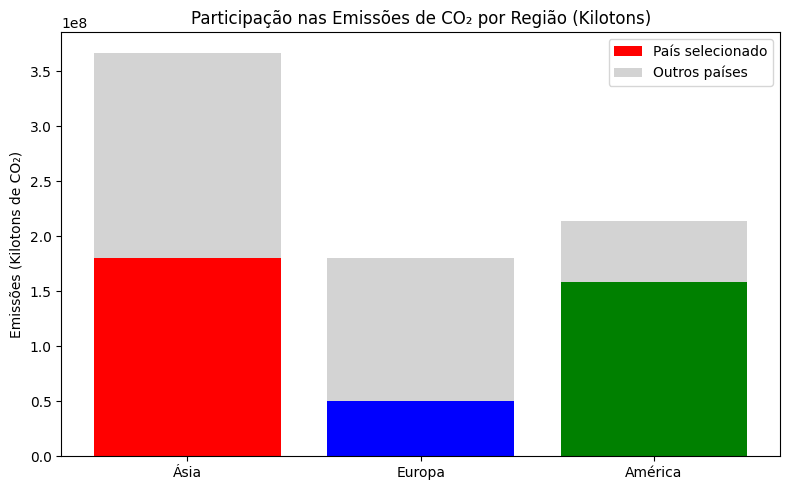

In [ ]:
# Valores absolutos (em Kilotons)
china_val = china.values[0]
asia_total = asia.values[0]
outros_asia = asia_total - china_val

russia_val = russia.values[0]
europa_total = europa.values[0]
outros_europa = europa_total - russia_val

eua_val = eua.values[0]
america_total = america.values[0]
outros_america = america_total - eua_val

# DataFrame com os dados
df = pd.DataFrame({
    'Região': ['Ásia', 'Europa', 'América'],
    'País': [china_val, russia_val, eua_val],
    'Outros': [outros_asia, outros_europa, outros_america]
})

# Plot stacked bar
plt.figure(figsize=(8, 5))
bar1 = plt.bar(df['Região'], df['País'], label='País selecionado', color=['red', 'blue', 'green'])
bar2 = plt.bar(df['Região'], df['Outros'], bottom=df['País'], label='Outros países', color='lightgray')

# Título e legendas
plt.title('Participação nas Emissões de CO₂ por Região (Kilotons)')
plt.ylabel('Emissões (Kilotons de CO₂)')
plt.legend()
plt.tight_layout()
plt.show()

A partir deste gráfico, é possível perceber a contribuição total de emissão dos top 3 países em suas respctivas regiões.

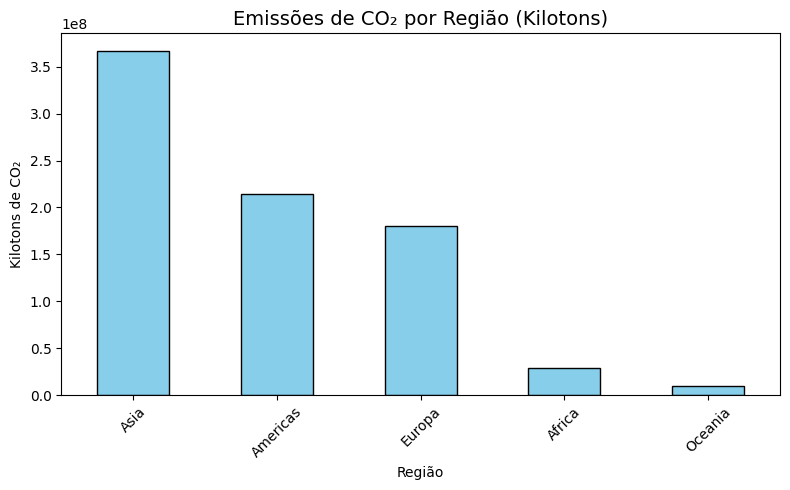

In [ ]:
# Agrupar por região e somar as emissões
emissoes_por_regiao = emissao_co2.groupby("Region")["Kilotons of Co2"].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
emissoes_por_regiao.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Emissões de CO₂ por Região (Kilotons)", fontsize=14)
plt.xlabel("Região")
plt.ylabel("Kilotons de CO₂")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Percebe-se que a região da Ásia é uma das que geram mais pegadas de CO2 em relação as demais regiões. A Oceania é a que menor gera pegadas de CO2.

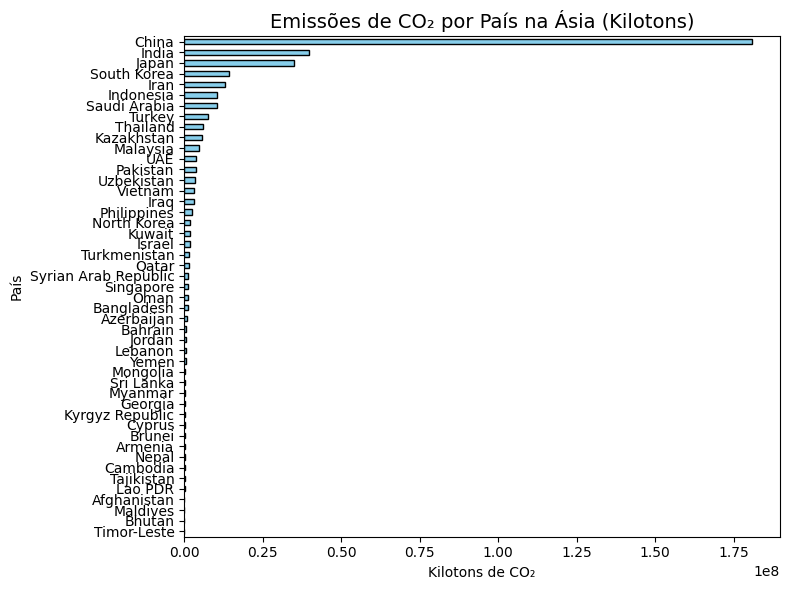

In [ ]:
# Agrupar por país e somar as emissões
emissoes_por_pais_asia = emissao_asia.groupby("Country")["Kilotons of Co2"].sum().sort_values(ascending=True)

# Plot com barras horizontais
plt.figure(figsize=(8, 6))
emissoes_por_pais_asia.plot(kind="barh", color="skyblue", edgecolor="black")

plt.title("Emissões de CO₂ por País na Ásia (Kilotons)", fontsize=14)
plt.xlabel("Kilotons de CO₂")
plt.ylabel("País")
plt.tight_layout()
plt.show()

Dentro da região da Ásia, a China lidera as emissões de CO2.

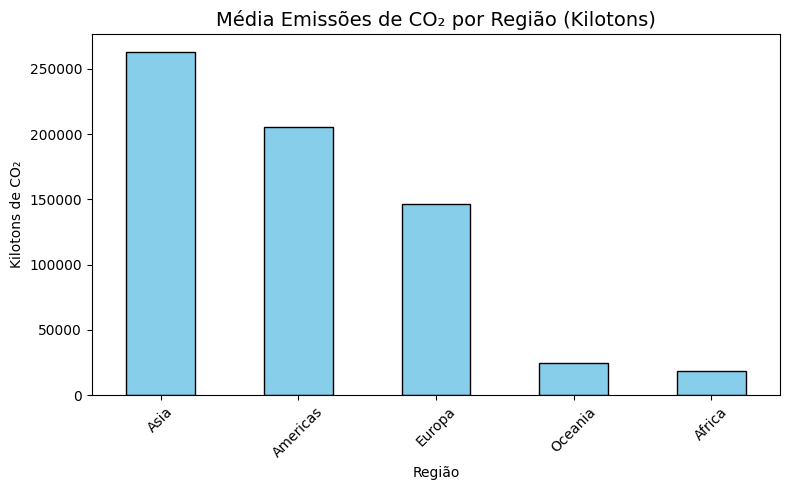

In [776]:
# Agrupar por região e somar as emissões
emissoes_por_regiao = emissao_co2.groupby("Region")["Kilotons of Co2"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
emissoes_por_regiao.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Média Emissões de CO₂ por Região (Kilotons)", fontsize=14)
plt.xlabel("Região")
plt.ylabel("Kilotons de CO₂")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

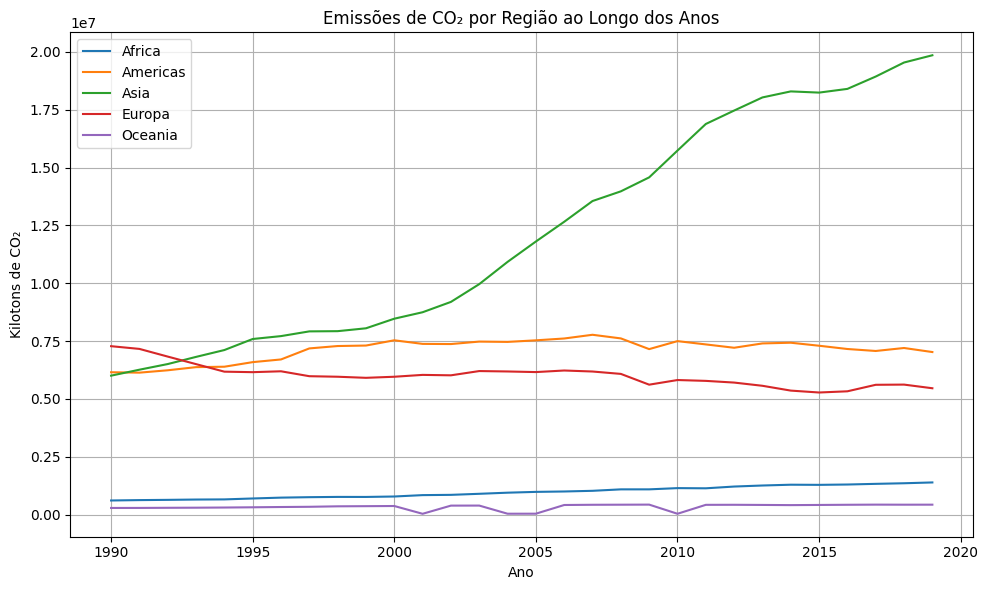

In [ ]:
# Garantir que a coluna 'Date' está em formato datetime
emissao_co2["Date"] = pd.to_datetime(emissao_co2["Date"])

# Criar uma nova coluna 'Ano'
emissao_co2["Ano"] = emissao_co2["Date"].dt.year

# Agrupar por ano e região
emissoes_ano_regiao = emissao_co2.groupby(["Ano", "Region"])["Kilotons of Co2"].sum().reset_index()

# Plotar um gráfico de linhas com uma linha para cada região
plt.figure(figsize=(10, 6))
for regiao in emissoes_ano_regiao["Region"].unique():
    df_r = emissoes_ano_regiao[emissoes_ano_regiao["Region"] == regiao]
    plt.plot(df_r["Ano"], df_r["Kilotons of Co2"], label=regiao)

plt.title("Emissões de CO₂ por Região ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Kilotons de CO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nesse gráfico, é possível constatar a discrepância de emissões de CO2 da Ásia em relação aos demais Continentes.

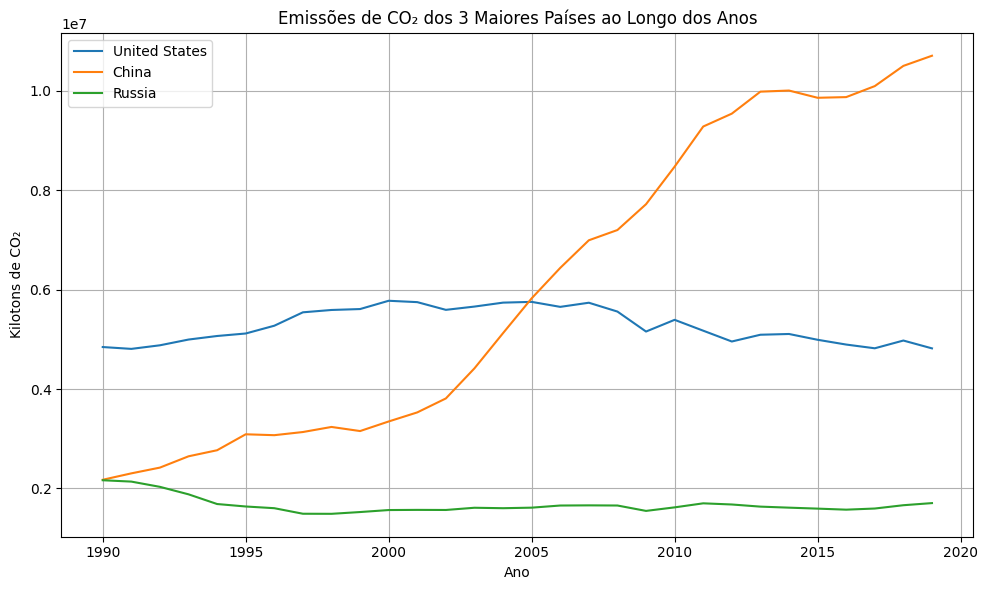

In [796]:
# Selecionar os N países com maior emissão total
top_paises = (
    emissao_co2.groupby("Country")["Kilotons of Co2"]
    .sum()
    .sort_values(ascending=False)
    .head(3)  # Altere esse número conforme necessário
    .index
)

# Filtrar apenas esses países no DataFrame
df_filtrado = emissao_co2[emissao_co2["Country"].isin(top_paises)]

# Plot
plt.figure(figsize=(10, 6))
for pais in df_filtrado["Country"].unique():
    df_p = df_filtrado[df_filtrado["Country"] == pais]
    plt.plot(df_p["Ano"], df_p["Kilotons of Co2"], label=pais)

plt.title("Emissões de CO₂ dos 3 Maiores Países ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Kilotons de CO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


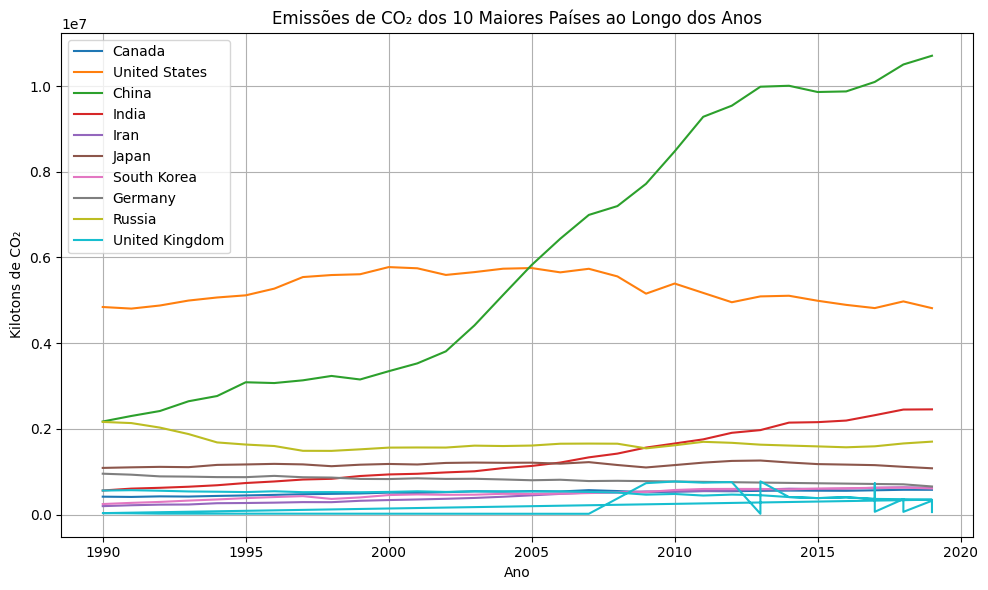

In [797]:
# Selecionar os N países com maior emissão total
top_paises = (
    emissao_co2.groupby("Country")["Kilotons of Co2"]
    .sum()
    .sort_values(ascending=False)
    .head(10)  # Altere esse número conforme necessário
    .index
)

# Filtrar apenas esses países no DataFrame
df_filtrado = emissao_co2[emissao_co2["Country"].isin(top_paises)]

# Plot
plt.figure(figsize=(10, 6))
for pais in df_filtrado["Country"].unique():
    df_p = df_filtrado[df_filtrado["Country"] == pais]
    plt.plot(df_p["Ano"], df_p["Kilotons of Co2"], label=pais)

plt.title("Emissões de CO₂ dos 10 Maiores Países ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Kilotons de CO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


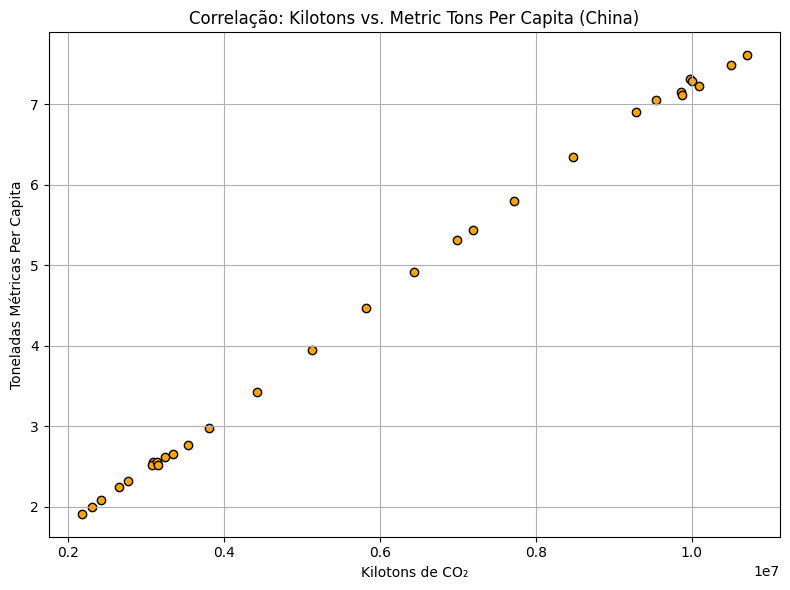

In [ ]:
# Filtrar dados da Austrália ou outro país se desejar
df_china = emissao_co2[emissao_co2["Country"] == "China"]

# Plotar a correlação
plt.figure(figsize=(8, 6))
plt.scatter(df_china["Kilotons of Co2"], df_china["Metric Tons Per Capita"], color="orange", edgecolor="black")

plt.title("Correlação: Kilotons vs. Metric Tons Per Capita (China)")
plt.xlabel("Kilotons de CO₂")
plt.ylabel("Toneladas Métricas Per Capita")
plt.grid(True)
plt.tight_layout()
plt.show()

Percebe-se neste gráfico, uma correlação positiva forte, para a China por exemplo, que é o maior emisssor. Se fôssemos calcular o coeficiente de pearson, estaria próximo a 1. O que nos indica que quanto maior a tonelada métrica per capita, maior a emissão em kilotons de CO2.

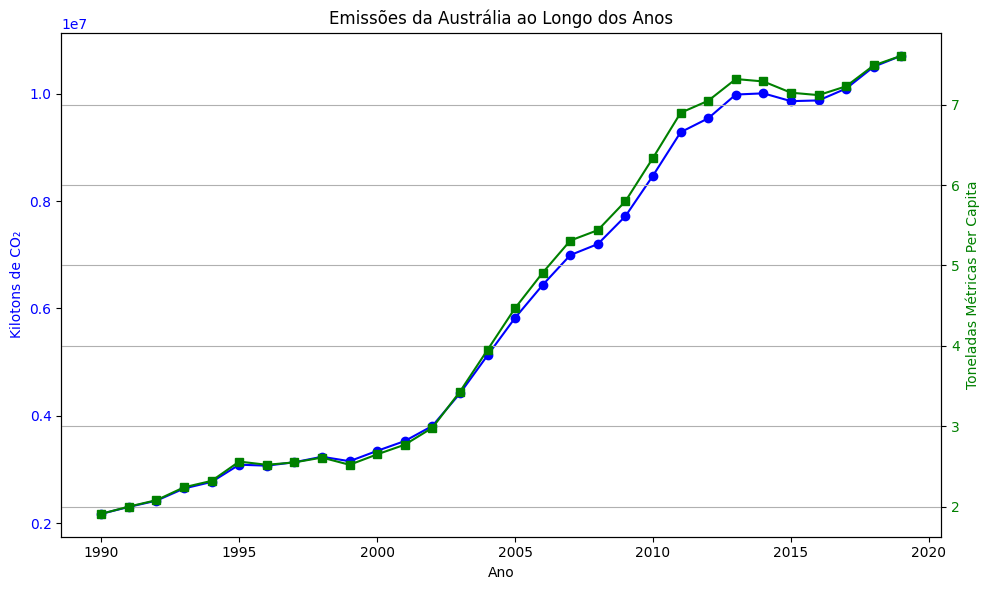

In [ ]:
# Garantir que a coluna 'Date' está no formato datetime e criar coluna 'Ano'
emissao_co2["Date"] = pd.to_datetime(emissao_co2["Date"])
emissao_co2["Ano"] = emissao_co2["Date"].dt.year

# Filtrar para a Austrália (ou outro país)
df_china = emissao_co2[emissao_co2["Country"] == "China"]

# Plot com dois eixos y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primeiro eixo (Kilotons of CO2)
ax1.set_title("Emissões da Austrália ao Longo dos Anos")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Kilotons de CO₂", color="blue")
ax1.plot(df_china["Ano"], df_china["Kilotons of Co2"], color="blue", marker="o", label="Kilotons CO₂")
ax1.tick_params(axis="y", labelcolor="blue")

# Segundo eixo (Metric Tons per Capita)
ax2 = ax1.twinx()
ax2.set_ylabel("Toneladas Métricas Per Capita", color="green")
ax2.plot(df_china["Ano"], df_china["Metric Tons Per Capita"], color="green", marker="s", label="Toneladas per Capita")
ax2.tick_params(axis="y", labelcolor="green")

plt.grid(True)
fig.tight_layout()
plt.show()

A partir desse gráfico, nota-se o crescimento acelerado de emissões da China, fato que pode ser corroborado com a alta industrialização do país.

C:\Users\rodri\AppData\Local\Temp\ipykernel_15776\272399225.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




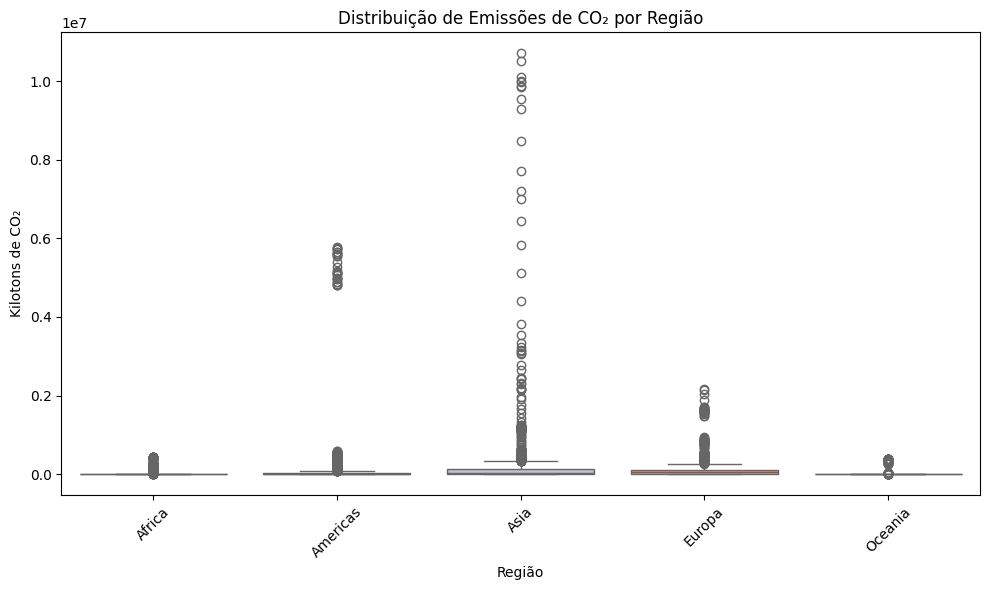

In [ ]:
# Garantir que não há valores nulos em 'Kilotons of Co2' e 'Region'
df_plot = emissao_co2.dropna(subset=["Kilotons of Co2", "Region"])

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Kilotons of Co2", data=df_plot, palette="Set3")

plt.title("Distribuição de Emissões de CO₂ por Região")
plt.xlabel("Região")
plt.ylabel("Kilotons de CO₂")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Neste boxplot, fica claro a discrepância de emissões do continente asiático, seguido pelo americano e o europeu. 